In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
!pip install torchinfo
from torchinfo import summary
from torch.utils.data import DataLoader, TensorDataset

In [23]:
## Step 1: Load and Preprocess Data
# Load training and test datasets
df_train = pd.read_csv("/content/testset.csv")
df_test = pd.read_csv("/content/trainset.csv")

In [24]:
# Use closing prices
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

In [25]:
# Normalize the data based on training set only
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)

In [26]:
# Create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)

In [27]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((65, 60, 1), (65, 1), (1199, 60, 1), (1199, 1))

In [28]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [29]:
# Create dataset and dataloader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [30]:
## Step 2: Define RNN Model
class RNNModel(nn.Module):
  def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
    super(RNNModel, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self,x):
    out, _ = self.rnn(x)
    out = self.fc(out[:, -1, :])
    return out

model = RNNModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
model = RNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [32]:
# input_size = (batch_size, seq_len, input_size)
summary(model, input_size=(64, 60, 1))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [64, 1]                   --
├─RNN: 1-1                               [64, 60, 64]              12,608
├─Linear: 1-2                            [64, 1]                   65
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 48.42
Input size (MB): 0.02
Forward/backward pass size (MB): 1.97
Params size (MB): 0.05
Estimated Total Size (MB): 2.03

In [33]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
## Step 3: Train the Model
epochs = 20
model.train()
train_losses = []
for epoch in range(epochs):
  epoch_loss = 0
  for x_batch, y_batch in train_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    optimizer.zero_grad()
    outputs = model(x_batch)
    loss = criterion(outputs, y_batch)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  train_losses.append(epoch_loss / len(train_loader))
  print(f"Epoch [{epoch+1}/{epochs}], Loss:{train_losses[-1]:.4f}")

Epoch [1/20], Loss:0.1607
Epoch [2/20], Loss:0.0830
Epoch [3/20], Loss:0.0330
Epoch [4/20], Loss:0.0840
Epoch [5/20], Loss:0.1659
Epoch [6/20], Loss:0.0323
Epoch [7/20], Loss:0.0343
Epoch [8/20], Loss:0.1507
Epoch [9/20], Loss:0.0520
Epoch [10/20], Loss:0.0570
Epoch [11/20], Loss:0.1317
Epoch [12/20], Loss:0.0445
Epoch [13/20], Loss:0.1152
Epoch [14/20], Loss:0.1282
Epoch [15/20], Loss:0.0897
Epoch [16/20], Loss:0.0414
Epoch [17/20], Loss:0.0515
Epoch [18/20], Loss:0.0473
Epoch [19/20], Loss:0.0677
Epoch [20/20], Loss:0.0523


Name: K S Vinay Suhirthan
Register Number: 212224230305


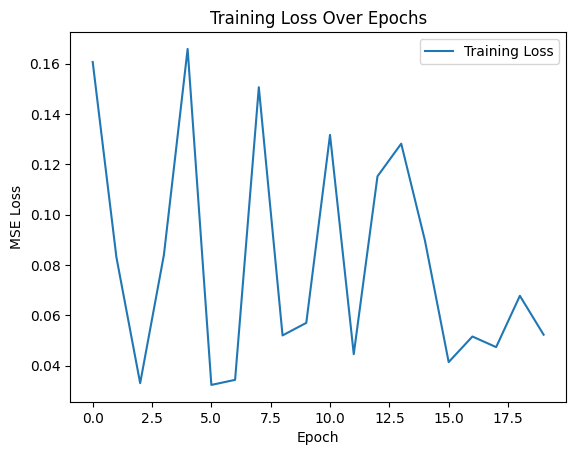

In [35]:
# Plot training loss
print('Name: K S Vinay Suhirthan')
print('Register Number: 212224230305')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

Name: K S Vinay Suhirthan
Register Number: 212224230305


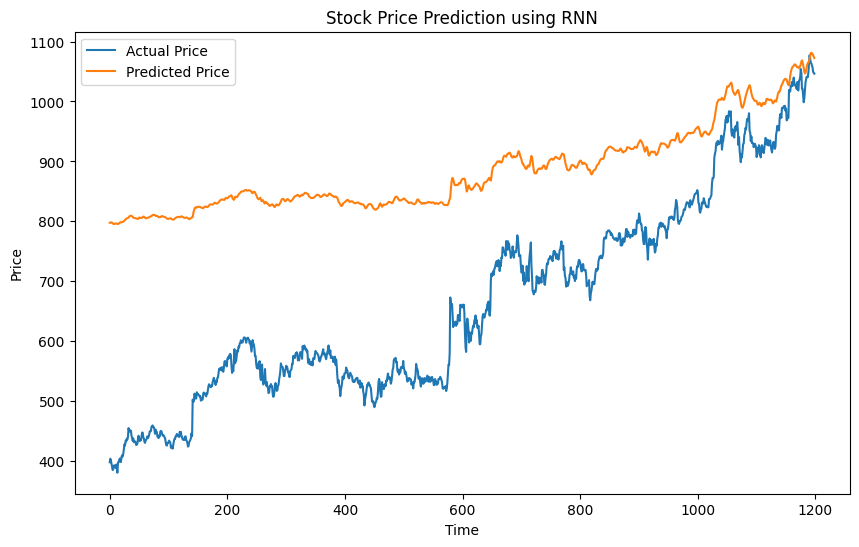

Predicted Price: [1072.5262]
Actual Price: [1046.4]


In [36]:
## Step 4: Make Predictions on Test Set
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

# Inverse transform the predictions and actual values
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

# Plot the predictions vs actual prices
print('Name: K S Vinay Suhirthan')
print('Register Number: 212224230305')
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')